In [2]:

# ~~~~~~~~~~~~~~ Libraries
import sys, os
import mne # Python package for processing and analyzing electrophysiological data
import numpy as np
from glob import glob # look for all the pathnames matching a specified pattern according to the rules
import matplotlib.pyplot as plt
from mne.preprocessing import ICA # ICA (Independent Component Analysis) algorithm, which is for artifact removal
from autoreject import AutoReject # Python package for automatically rejecting bad epochs in EEG/MEG data
import json
import owncloud


In [33]:
# ~~~~~~~~~~~~~~ Environment

# open parent folder of this script
os.chdir('/Users/muku/Desktop/Ph.D_MaxPlanck/Research/MINT/code')

with open("config.json") as f: # The file object is referenced as f during the block.
    config = json.load(f) 
globals().update(config)
sys.path.append(BASE_DIR) # import custom python packages

# import cusom functions
from utils import create_if_not_exist, download_datashare_dir, update_eeg_headers, make_31_montage, calculate_artificial_channels

# get arguments
modality = 'visual'
session = 1
print(f"\n\n Processing {modality} EEG session {session} \n\n")






 Processing visual EEG session 1 




In [34]:
# create directories
create_if_not_exist(f"{BASE_DIR}/data/raw/{modality}/session_{session}") #  "BASE_DIR": "/Users/muku/Desktop/Ph.D_MaxPlanck/Research/MINT"
create_if_not_exist(f"{BASE_DIR}/data/interim/{modality}/session_{session}")
create_if_not_exist(f"{BASE_DIR}/data/processed/{modality}/session_{session}")

In [45]:
# access to owncloud where raw data is stored
datashare = owncloud.Client('https://datashare.mpcdf.mpg.de')
DATASHARE_USER = 'kazma'
DATASHARE_PASS = 'Xt98iCm4XQHH!vf' # my MPCDF password
datashare.login(DATASHARE_USER, DATASHARE_PASS) # replace with actual username and password

# List root directory to check if login works
files = datashare.list('/MINT/raw')
# Print only the file names
for file in files:
    # Get only the name, not the full path
    file_name = file.path  # Extracts the last part of the path
    print(f'{file_name} will be locally donwloaded from owncloud')
    print(file.name)

/MINT/raw/audio/ will be locally donwloaded from owncloud
audio
/MINT/raw/visual/ will be locally donwloaded from owncloud
visual


In [47]:
TARGET_FOLDER = os.path.join(BASE_DIR, 'data', 'raw')

# Loop over session folders on DataShare
for file in files:
    # Explicity exclude certain file names
    if file.name.startswith('._'):
        continue

    # Download if it doesn't exist
    local_file = os.path.join(TARGET_FOLDER, file.name)
    if not os.path.exists(local_file): 
        
        # Download zip file
        print(f'Downloading {file.path} to {local_file}')
        create_if_not_exist(TARGET_FOLDER)
        datashare.get_file(file, local_file)        
    else:
        print(f"File {local_file} already exists. Skipping download.")

Reading /viper/u/kazma/MINT/data/interim/visual/sub-01_ses-01/epochs-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
1260 matching events found
No baseline correction applied
0 projection items activated


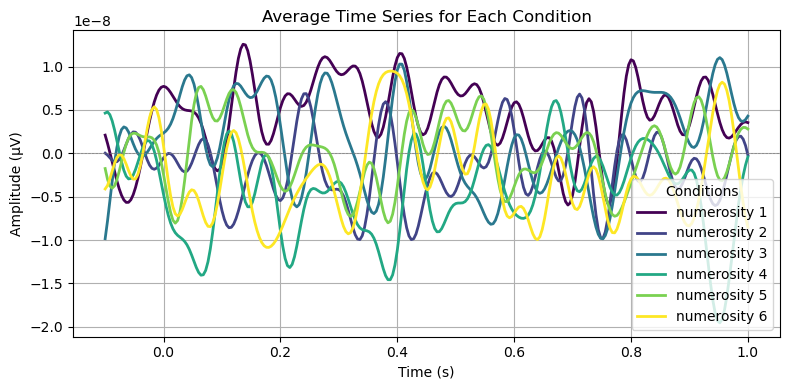

In [10]:
os.chdir('/u/kazma/MINT/data/interim/visual/sub-01_ses-01')

# Replace 'file.fif' with the path to your .fif file
epochs = mne.read_epochs('epochs-epo.fif', preload=True)

condition_names = list(epochs.event_id.keys())
evoked_list = []

for condition in condition_names:
    evoked = epochs[condition].average()  # Average the epochs for the condition
    evoked_list.append(evoked)

# Step 3: Create a single figure and overlay the plots
plt.figure(figsize=(8, 4))

# Set a color map for different conditions
colors = plt.cm.viridis(np.linspace(0, 1, len(evoked_list)))

for i, evoked in enumerate(evoked_list):
    # Average across all channels
    avg_data = evoked.data.mean(axis=0)  # Mean across all channels
    times = evoked.times  # Time vector
    
    plt.plot(times, avg_data, label=condition_names[i], color=colors[i], linewidth=2)  # Plot average time series

# Customize the plot
plt.title('Average Time Series for Each Condition')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)  # Add a horizontal line at y=0
plt.legend(title='Conditions')
plt.grid()
plt.tight_layout()
plt.show()
